In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import pandas as pd
import glob2
import os
from itertools import product
import numpy as np
import pickle
#import seaborn as sns

#%matplotlib notebook
#%matplotlib
%matplotlib inline
from logic_inspect import show_composite
from tboard import file2number
from nonlinearities import sigmoid
from vis_utils import (split_posneg , get_path, get_np_network,
                        get_neuron_values, splitL, load_weights,
                        resample_grid,vec_get_neuron_values,
                        get_del_weights  )
from vis_utils import Pub_Model_Dirs, clist,listLineStyle
from calc_bounds import param_counter
from sklearn.metrics import classification_report
from sympy import preorder_traversal,postorder_traversal
import sympy
#clist=['g','c','m','y','k','b','r']
#listLineStyle=['solid', 'dashed', 'dashdot', 'dotted']
from calc_maps import get_net_states
from sklearn import svm

from maxmargin_compare import get_state_fn,get_gram_fn
from maxmargin_compare import paint_data

figure_folder='./figures/'

In [120]:
###Index by [arch#-1][data#-1]
Arch=1
Data=3
log_dir=Pub_Model_Dirs[Arch-1][Data-1]
descrip,id_str=log_dir.split('_')[-1],str(file2number(log_dir))
print 'using log_dir:',log_dir,' descrip:',descrip, 'id str:',id_str

record_dir=os.path.join(log_dir,'records')
pactensor_dir=os.path.join(log_dir,'pac-tensor')
if not os.path.exists(pactensor_dir):
    os.makedirs(pactensor_dir)

using log_dir: ./logs/Pub_Model_0504_234822_D3A1  descrip: D3A1 id str: 504234822


In [121]:
all_step=np.load(get_path('step','wwatch',log_dir))
all_weights=load_weights(log_dir)#d*2*Txn1xn2
del_weights=get_del_weights(all_weights)
arch=[b.shape[-1] for w,b in del_weights[:-1]]#net architecture

##For time iter
# iter_slice=np.arange(len(all_step))
# dt=10#every 100
# iter_slice=iter_slice[::dt]
# #print 'dt=',dt
# # iter_slice=iter_slice[-1:]#just last entry
# step=all_step[iter_slice]
# step_weights=[[w[iter_slice],b[iter_slice]] for w,b in all_weights]
# step_dweights=[[w[iter_slice],b[iter_slice]] for w,b in del_weights]#d*2*dTxn1xn2
# time_weights=[[w[-1],b[-1]] for w,b in del_weights]#d*2*n1xn2

npX=np.load(os.path.join(record_dir,'dataX.npy'))
npY=np.load(os.path.join(record_dir,'dataY.npy'))
Xpos,Xneg,Ypos,Yneg=split_posneg(npX,npY)
m_samples,xdim=npX.shape
gridX=np.load(get_path('gridX','hmwatch',log_dir))
gX=resample_grid(gridX,1000)
gX0,gX1=gX[:,:,0],gX[:,:,1]
X,Y=npX,npY.ravel()
fl_gX=gX.reshape([-1,xdim])



# weights=[[w[trn_iter],b[trn_iter]] for w,b in step_dweights]#d*2*wtshape

trn_iter=-1
# trn_iter=100

weights=[[w[trn_iter],b[trn_iter]] for w,b in del_weights]#d*2*wtshape
Wweights,Bweights=zip(*weights)

In [122]:
get_states=get_state_fn(weights)
get_gram=get_gram_fn(Bweights,get_states)

gram=get_gram(X,X)
gram_flgrid=get_gram(fl_gX,X)

In [123]:
##Sometimes doesnt fit due to class imbalance issues
clf=svm.SVC(kernel='precomputed',
           #C=1e-2,
           C=1e-5,
#             C=0.,#ERR
           #C=1.,
           tol=0.0001,
#            shrinking=False,
           )
clf.fit(gram,Y)
print 'Model Fit'
correct=clf.predict(gram)==Y
if not correct.all():
    print 'Warn not all learned'
    wh_bad=np.where(correct==False)[0]
alpha=clf.dual_coef_
#svm_dec=clf.decision_function(gram)
#recon=np.sum(gram[:,clf.support_]*alpha,axis=-1)+clf.intercept_
#Good. dec==recon True

#clf.predict(n_samples_test x n_samples_train)(when kernel='precomputed')


#svm_pred=np.reshape(clf.predict(gram_flgrid),gX.shape[:xdim])
svm_fn=np.reshape(clf.decision_function(gram_flgrid),gX.shape[:xdim])
net_fn=vec_get_neuron_values(gX,weights)[-1].reshape(gX.shape[:xdim])
svm_pred=np.sign(svm_fn)
net_pred=np.sign(net_fn)

svm_fn/=np.max(np.abs(svm_fn))
net_fn/=np.max(np.abs(net_fn))

net_X=vec_get_neuron_values(X,weights)[-1]
print 'SVM score',clf.score(gram,Y)
print 'NN score', np.mean(np.sign(net_X)==npY) 

Model Fit
Warn not all learned
SVM score 0.85
NN score 1.0


In [138]:
from sklearn.svm import LinearSVC
lin=LinearSVC(C=1e-3,tol=1e-5,dual=True,loss='hinge')
lin.fit(gram,Y)
lin.score(gram,Y)

0.975

# Something is up with the gram implementation because training embedding doenst seem linearly separable

In [128]:
def plot(gX,weights,net_fn,svm_fn):
    # fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))


    cmap = plt.cm.get_cmap("Purples")
    #my_cmap = cmap(np.arange(cmap.N))
    #my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    lvls=np.arange(-1,1.,0.2)

    plt.tight_layout()
    plt.xticks([]) # labels 
    plt.yticks([])

    paint_data(ax1,X,Y)
    paint_data(ax2,X,Y)
    # for ax in [ax1,ax2]:
    #     ax.xaxis.set_ticks_position('none') # tick markers
    #     ax.yaxis.set_ticks_position('none')
    #     ax.scatter(Xpos[:,0],Xpos[:,1],marker='+',s=600,c='b',linewidth='3')
    #     ax.scatter(Xneg[:,0],Xneg[:,1],marker='_',s=600,c='r',linewidth='3')

    # ctf1=ax1.contourf(gX0,gX1,net_fn,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
    # ctf2=ax2.contourf(gX0,gX1,svm_pred,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
    ctf1=ax1.contourf(gX0,gX1,net_fn,
    #                   levels=[-1.01,0,1.01],
                      levels=lvls,
    #                   colors=['w',cmap(190)],
                      cmap=plt.get_cmap('PuOr'),
                      alpha=0.5,
    #                   anti_aliasing=True,
                     )
    ctf2=ax2.contourf(gX0,gX1,svm_fn,
    #                   levels=[-1.01,0,1.01],
                      levels=lvls,
    #                   colors=['w',cmap(190)],
                      cmap=plt.get_cmap('PuOr'),
                      alpha=0.5,
    #                   anti_aliasing=True,
                     )
    ax3.contour(gX0,gX1,svm_fn,
    #                   levels=[-1.01,0,1.01],
                      levels=lvls,
                        colors='r',
#                 linestyles='solid',
#                 linestyles='dotted',
    #                   colors=['w',cmap(190)],
    #                   cmap=plt.get_cmap('PuOr'),
    #                   alpha=0.5,
    #                   anti_aliasing=True,
                     )
    PLayers=vec_get_neuron_values(gX,weights)[:-1]
    for l_Act in PLayers:
        listL=splitL(l_Act)
        for Pneu in listL:
            ax3.contour(gX0,gX1,Pneu,levels=[0.],colors='k',linestyles='solid')



    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ctf2, cax=cbar_ax)

    # im1=ax1.imshow(net_fn[::-1],vmin=-1,vmax=+1)
    # im2=ax2.imshow(svm_fn[::-1],vmin=-1,vmax=+1)
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(im1, cax=cbar_ax)


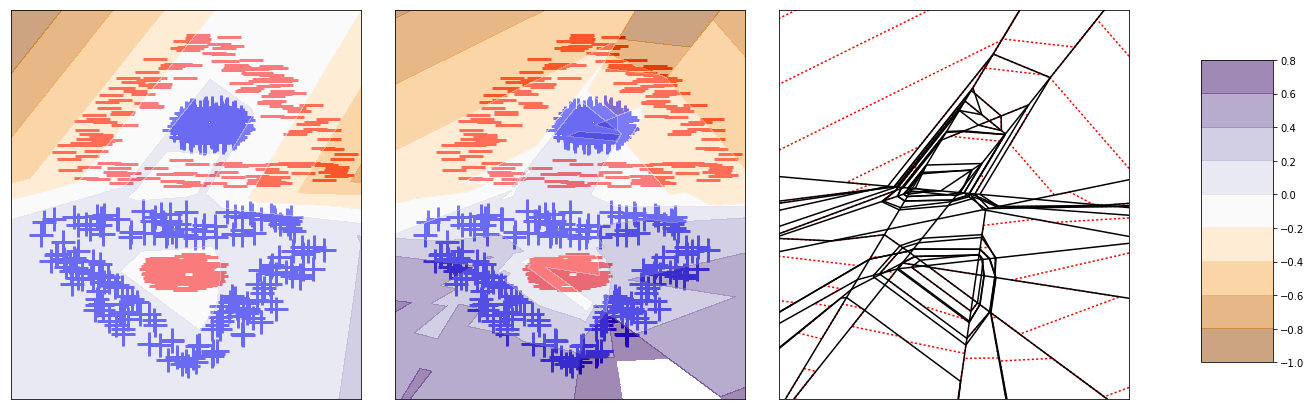

In [129]:
plot(gX,weights,net_fn,svm_fn)

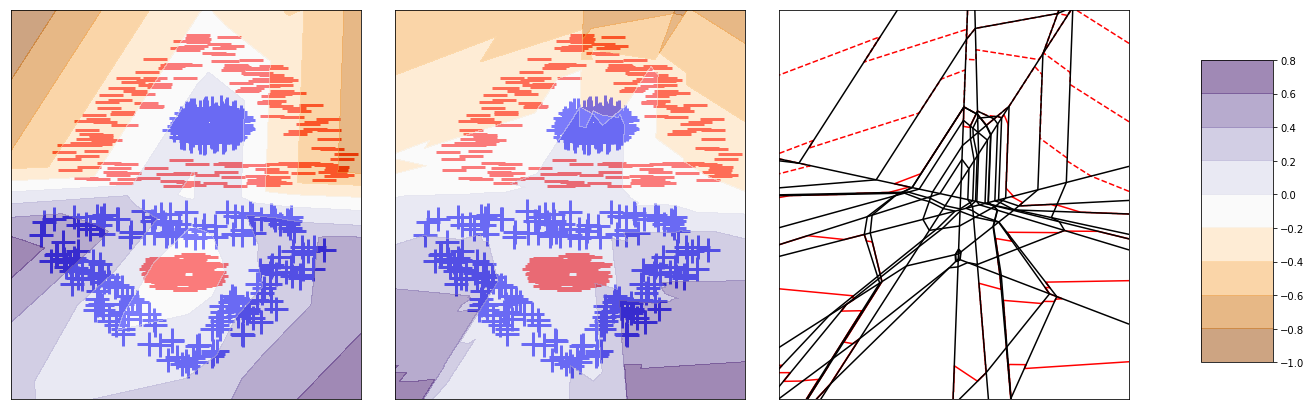

In [76]:
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))


cmap = plt.cm.get_cmap("Purples")
#my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
lvls=np.arange(-1,1.,0.2)

plt.tight_layout()
plt.xticks([]) # labels 
plt.yticks([])

paint_data(ax1,X,Y)
paint_data(ax2,X,Y)
# for ax in [ax1,ax2]:
#     ax.xaxis.set_ticks_position('none') # tick markers
#     ax.yaxis.set_ticks_position('none')
#     ax.scatter(Xpos[:,0],Xpos[:,1],marker='+',s=600,c='b',linewidth='3')
#     ax.scatter(Xneg[:,0],Xneg[:,1],marker='_',s=600,c='r',linewidth='3')

# ctf1=ax1.contourf(gX0,gX1,net_fn,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
# ctf2=ax2.contourf(gX0,gX1,svm_pred,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
ctf1=ax1.contourf(gX0,gX1,net_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ctf2=ax2.contourf(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ax3.contour(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
                    colors='r',
            linestyle='solid',
#                   colors=['w',cmap(190)],
#                   cmap=plt.get_cmap('PuOr'),
#                   alpha=0.5,
#                   anti_aliasing=True,
                 )
PLayers=vec_get_neuron_values(gX,weights)[:-1]
for l_Act in PLayers:
    listL=splitL(l_Act)
    for Pneu in listL:
        ax3.contour(gX0,gX1,Pneu,levels=[0.],colors='k',linestyle='solid')
        
        
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ctf2, cax=cbar_ax)

# im1=ax1.imshow(net_fn[::-1],vmin=-1,vmax=+1)
# im2=ax2.imshow(svm_fn[::-1],vmin=-1,vmax=+1)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im1, cax=cbar_ax)


## t=500

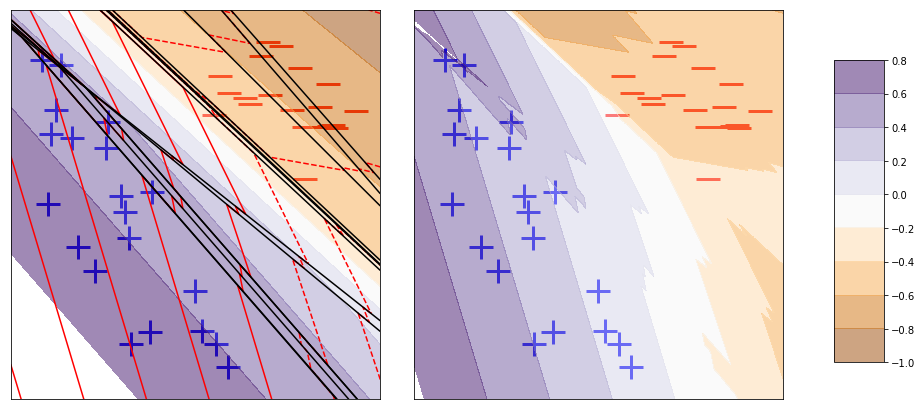

In [69]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

cmap = plt.cm.get_cmap("Purples")
#my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
lvls=np.arange(-1,1.,0.2)

plt.tight_layout()
plt.xticks([]) # labels 
plt.yticks([])

paint_data(ax1,X,Y)
paint_data(ax2,X,Y)
# for ax in [ax1,ax2]:
#     ax.xaxis.set_ticks_position('none') # tick markers
#     ax.yaxis.set_ticks_position('none')
#     ax.scatter(Xpos[:,0],Xpos[:,1],marker='+',s=600,c='b',linewidth='3')
#     ax.scatter(Xneg[:,0],Xneg[:,1],marker='_',s=600,c='r',linewidth='3')

# ctf1=ax1.contourf(gX0,gX1,net_fn,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
# ctf2=ax2.contourf(gX0,gX1,svm_pred,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
ctf1=ax1.contourf(gX0,gX1,net_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ctf2=ax2.contourf(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ax1.contour(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
                    colors='r',
#                   colors=['w',cmap(190)],
#                   cmap=plt.get_cmap('PuOr'),
#                   alpha=0.5,
#                   anti_aliasing=True,
                 )
PLayers=vec_get_neuron_values(gX,weights)[:-1]
for l_Act in PLayers:
    listL=splitL(l_Act)
    for Pneu in listL:
        ax1.contour(gX0,gX1,Pneu,levels=[0.],colors='k')
        
        
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ctf2, cax=cbar_ax)

# im1=ax1.imshow(net_fn[::-1],vmin=-1,vmax=+1)
# im2=ax2.imshow(svm_fn[::-1],vmin=-1,vmax=+1)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im1, cax=cbar_ax)


## last time point

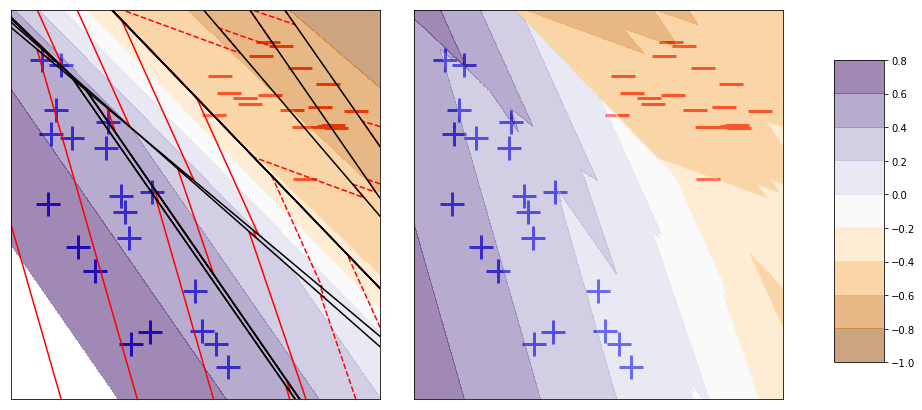

In [49]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

cmap = plt.cm.get_cmap("Purples")
#my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
lvls=np.arange(-1,1.,0.2)

plt.tight_layout()
plt.xticks([]) # labels 
plt.yticks([])

paint_data(ax1,X,Y)
paint_data(ax2,X,Y)
# for ax in [ax1,ax2]:
#     ax.xaxis.set_ticks_position('none') # tick markers
#     ax.yaxis.set_ticks_position('none')
#     ax.scatter(Xpos[:,0],Xpos[:,1],marker='+',s=600,c='b',linewidth='3')
#     ax.scatter(Xneg[:,0],Xneg[:,1],marker='_',s=600,c='r',linewidth='3')

# ctf1=ax1.contourf(gX0,gX1,net_fn,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
# ctf2=ax2.contourf(gX0,gX1,svm_pred,levels=[-1.01,0,1.01],colors=['w',cmap(190)],alpha=0.5)
ctf1=ax1.contourf(gX0,gX1,net_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ctf2=ax2.contourf(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
#                   colors=['w',cmap(190)],
                  cmap=plt.get_cmap('PuOr'),
                  alpha=0.5,
#                   anti_aliasing=True,
                 )
ax1.contour(gX0,gX1,svm_fn,
#                   levels=[-1.01,0,1.01],
                  levels=lvls,
                    colors='r',
#                   colors=['w',cmap(190)],
#                   cmap=plt.get_cmap('PuOr'),
#                   alpha=0.5,
#                   anti_aliasing=True,
                 )
PLayers=vec_get_neuron_values(gX,weights)[:-1]
for l_Act in PLayers:
    listL=splitL(l_Act)
    for Pneu in listL:
        ax1.contour(gX0,gX1,Pneu,levels=[0.],colors='k')
        
        
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ctf2, cax=cbar_ax)

# im1=ax1.imshow(net_fn[::-1],vmin=-1,vmax=+1)
# im2=ax2.imshow(svm_fn[::-1],vmin=-1,vmax=+1)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im1, cax=cbar_ax)


In [36]:
ctf2.levels

array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

In [18]:
Y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

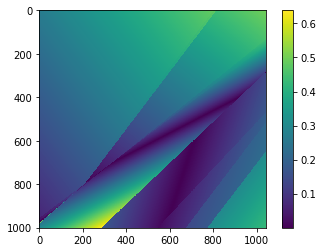

In [12]:
diff=np.abs(svm_fn-net_fn)
plt.imshow(diff)
plt.colorbar()

In [9]:
rel_diff.min()

-36162.80804376206